<a href="https://colab.research.google.com/github/JoaoGustavo29/Portfolio_DataScience/blob/master/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 2.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# instalar pacotes necessários
! pip install -q scikit-plot

In [ ]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# importar Warnings filter
from warnings import simplefilter

# ignorar futuros warnings
simplefilter(action='ignore', category=FutureWarning)

# configurar notebook
sns.set_style('dark')

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Esse foi um dos projetos mais extensos que já fiz e por isso vou mostrar como ficou dividido, assim você (leitor) pode ir direto até a parte que lhe interessa.

O projeto ficou dividido da seguinte forma: 


*   Análise Exploratória

*   Limpeza dos Dados

*   Processamento dos Dados com Label Encoder e Get Dummies

*   Preparação dos Dados

  * Padronização e Balanceamento dos dados

      * Balanceamento com Random UnderSampling 

      * Balanceamento com OverSampling SMOTE

      * Balanceamento com OverSampling ADASYN

  * Avaliando Modelos com Cross-Validation (Dados Balanceados e Padronizados)

  * Balanceamento RUS
      
      * StandardScaler
      
      * RobustScaler

      * Quantile Transformer

      * Quantile Transformer-Uniform

      * PowerTransformer

  * Balanceamento SMOTE

  * Balanceamento ADASYN

  * Definindo Modelos para o Balanceamento RUS
      
      * LinearDiscriminantAnalysis

      * SVC

      * XGBoost

  * Método Ensemble para os Modelos do Balanceamento RUS
      
      * Voting Classifier (RUS)

  * Definindo Modelos para o Balanceamento SMOTE
      
      * Random Forest

      * XGBoost

      * LinearDiscriminantAnalysis

  * Método Ensemble para os Modelos do Balanceamento SMOTE
      
      * Voting Classifier (SMOTE)

  * Definindo Modelos para o Balanceamento ADASYN
      
      * Random Forest

      * XGBoost

      * LinearDiscriminantAnalysis

  * Método Ensemble para os Modelos do Balanceamento ADASYN
      
      * Voting Classifier (ADASYN)

* Conclusão

Primeiro, vamos aprender o que é churn, de forama geral o churn é o número de clientes que cancelam um serviço em um determinado período de tempo, afim de solucionar ou ameinzar essa número, as empresas podem utilizar modelos de machine learning para prever se um cliente pretende ou não cancelar o serviço.

Os modelos de machine learning presentes no projeto, têm o objettivo de auxiliar empresas a lidar com o churn. Para isso, foram construídos modelos de aprendizagem supervisionada, como métrica para validação usamos o **recall** e para sabermos a perfomance minima esperada, podemos usar o **AUC (Área sob a Curva)**, sendo este necessário um score de **ao menos 0.70**.





# Análise Exploratória

Vamos começar nossa análise imprimindo as dimensões do DataFrame, após isso checar o nome das colunas e seus respectivos tipos de dados e também realizar uma checagem de quantos valores **únicos** temos por coluna. Sabendo a quantidade de valores únicos por coluna, podemos identificar colunas que podem ou não ser categóricas.

In [ ]:
# Checar as dimensões do DataFrame
print(f'O DataFrame possui {df.shape[0]} entradas e {df.shape[1]} colunas.')

# Checar o nome das colunas
print(f'\nNome das Colunas:\n{df.columns.values}')

# Checar o tipo de dados (por coluna)
print(f'\nTipos de dados (por coluna)\n{df.dtypes}')

# Checar os valores únicos por coluna
print(f'\nValores únicos (por coluna)\n{df.nunique()}')


O DataFrame possui 7043 entradas e 21 colunas.

Nome das Colunas:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Tipos de dados (por coluna)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: ob

Para uma análise bem feita é necessário também checar a quantidade de dados ausentes.

In [ ]:
# Checar a quantidade de dados ausentes
print(f'Porcentagem de dados ausentes:\t\n{df.isnull().sum() / df.shape[0]}')

Porcentagem de dados ausentes:	
customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


Note que existem algumas observações a serem feitas:

* A coluna `customerID` é insignificante para a análise, uma vez que apenas nos fornece o identificador de cada cliente.

* A variável alvo está presente na coluna `Churn`, ela indica se o cliente cancelou ou não o serviço.

* A coluna `TotalCharges` assim como a coluna `MonthlyCharges`, apresenta valores flutuantes, mas está com como string uma vez que seu tipo de dado deveria ser `flaot`.

* Diversas colunas vão precisar de um trabalho de codificação, transformando-as em valores numéricos.

* Apesar do nosso código retornar que não há valores ausentes, pode ser que algumas strings representem valores ausentes.



# Limpeza dos Dados

Anteriormente foi dito que a coluna `TotalCharges` deveria ser apresentada como `flaot`, mas estava sendo apresentada como uma string. 

Devido a isso, fui obrigado a usar um método mais complexo para converter a coluna, pois ao usar 
`df[TotalCharges].astype('float32')` é retornado um erro.

O erro em questão acontece devido ao dados ausentes terem sido preenchidos com `""`. Uma vez que tentamos converter `""` para float, o interpretador nos retorna um erro.

Para contornar esse erro e converter de forma adequada foi criada uma função para lidar com o erro. Consequentemente, foi possível identificar valores ausentes, que logo foram preenchidos com o valor da mediana da coluna.

Também foi excluída a coluna `customerID`, uma vez que é desnecessária para o projeto.

In [ ]:
def str_to_float(entrada):
  """
  Converte um objeto do tipo string em float.

   Caso seja possível a string sera convertida em float
   
   Se a conversão no for permitida, a string é convertida em um valor NaN
  """
  
  try:
    return float(entrada)
  except ValueError:
    return np.nan

# Criar cópia do DataFrame
df_clean = df.copy()

# Excluir a coluna customerID
df_clean.drop('customerID', axis=1, inplace=True)

# Aplicando a função de conversão 
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(str_to_float)

# Mostrar a quantidade de dados ausentes antes do preenchimento
print('Dados ausentes em "TotalCharges" antes de preencher os dados: {}'.format(df_clean['TotalCharges'].isnull().sum()))

# Preencher os dados ausentes com o valor da mediana da coluna
total_charges_median = df_clean.TotalCharges.median()
df_clean['TotalCharges'].fillna(total_charges_median, inplace=True)

Dados ausentes em "TotalCharges" antes de preencher os dados: 11


Apesar de o DataFrame ser majoritariamente de variáveis categóricas, possuímos algumas variáves numéricas que com o método `describe` é possível notar que não há a presença de outliers.

In [ ]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


É possível confirmar a falta de outliers quando analisamos os boxplots das colunas `MonthlyCharges` e `TotalCharges`, uma vez que mesmo sem definirmos limites não foi encontrado nenhum plot fora dos limites.

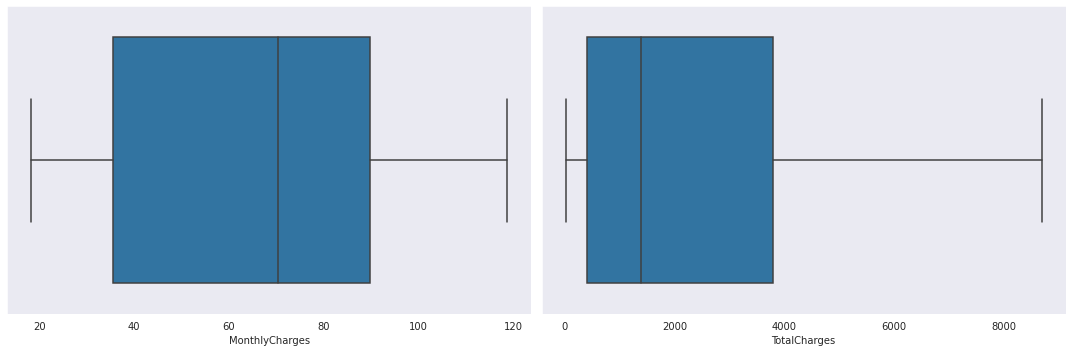

In [ ]:
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])

plt.tight_layout();

Para termos uma noção de quanto tempo um cliente permanece no serviço, podemos verificar essa "Fidelidade" plotando um gráfico de barras da varáivel `tenure`, que provavelmente usa como unidade de tempo o "mês".

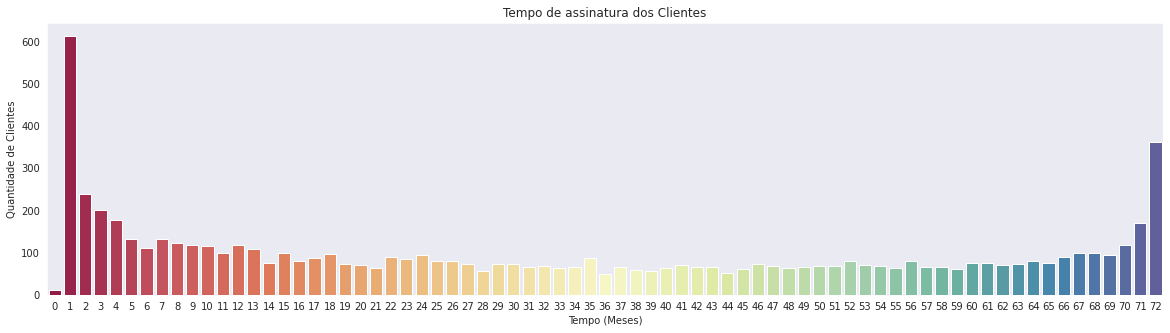

In [ ]:
# Plotar o gráfico
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(df_clean['tenure'], data=df_clean, palette='Spectral', ax=ax)

# Definir legendas para o gráfico
ax.set_title('Tempo de assinatura dos Clientes')
ax.set_ylabel('Quantidade de Clientes')
ax.set_xlabel('Tempo (Meses)')

plt.show();

Ao lidar com variáveis categóricas, se torna necessário identificar os valores únicos. 

Abaixo podemos ver que existem valores que podem ser unificados, como por exemplo:
* `No`

* `No phone service`

* `No internet service`.

Para isso, irei apenas definir os valores como No, assim os não teremos valores que representam a mesma coisa.

In [ ]:
# verificar valroes unicos para variaveis categoricas
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

In [ ]:
# Substituindo "No phone service" e "No internet service" por "No"
df_clean.replace({'No internet service': 'No'}, regex=True, inplace=True)
df_clean.replace({'No phone service': 'No'}, regex=True, inplace=True)

In [ ]:
# Checando a mudança nos valores únicos
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'One year', 'Two year', 'Yes'],
      dtype=object)

Para concluir a análise exploratória, vou verificar o balancemanto das classes.

É notável a diferença entre as classes, uma vez que a classe `No` ocorre com frequência superior à classe `Yes`. Para obtermos melhores resultados com nossos modelos de Machine Learning é necessário fazer o balanceamento das classes, isso será feito ao decorrer do projeto.

No     5174
Yes    1869
Name: Churn, dtype: int64

Churns representam 26.5370% do dataset.



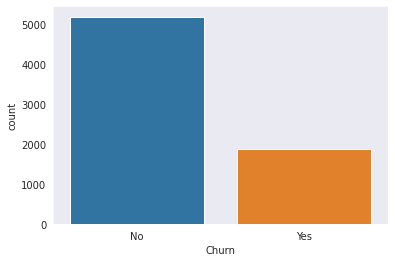

In [ ]:
# Plotar gráfico das classes
print(df_clean.Churn.value_counts())
print('\nChurns representam {:.4f}% do dataset.\n'.format((df_clean[df_clean.Churn == "Yes"].shape[0] / df.shape[0]) * 100))

sns.countplot(df_clean.Churn)
plt.show();

# Processamento dos Dados com Label Encoder e Get Dummies

Nesta etapa é necessário um pré-processamento dos dados. As colunas binárias (que possuem apenas dois valores únicos), serão processadas usando o `LabelEncoder`, incluindo a variável alvo `Churn`.

Em seguida, as variáveis serão separadas em categóricas e numéricas, onde as variáveis categóricas serão tratadas com o `getDummies`, assim poderão ser utilizadas em todos os modelos.

In [ ]:
variaveis_binarias = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
variaveis_numericas = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in variaveis_binarias]
variaveis_categoricas = [col for col in df_clean.columns.tolist() if col not in variaveis_binarias + variaveis_numericas]

df_clean_proc = df_clean.copy()

le = LabelEncoder()
for i in variaveis_binarias:
  df_clean_proc[i] = le.fit_transform(df_clean_proc[i])

df_clean_proc = pd.get_dummies(df_clean_proc, columns=variaveis_categoricas)

df_clean_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


É possível notar que mesmo sem fazer um balanceamento dos dados e uma padronização, temos uma boa correlação entre algumas variáveis, que possivelmente ficará ainda melhor após estes processos.

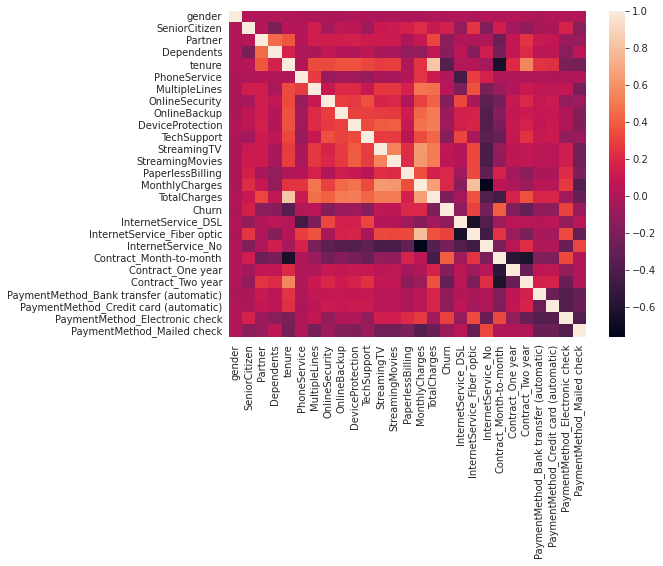

In [ ]:
# Plotar matriz de correlação
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_clean_proc.corr())

plt.show();

# Preparação dos Dados

Nesta seção, vou realizar a separaçao do nosso DF em treino e teste e identificar a nossa variável alvo. Além de também efetuar a padronização dos dados, será feita uma avaliação dos modelos por meio do Cross-Validation com os dados desbalanceados e posteriormente com os dados balanceados e padronizados.

**Separar os dados entre feature matrix e target vector**

In [ ]:
# separar os dados enter feature matrix e target vector
X = df_clean_proc.drop('Churn', axis=1)
y = df_clean_proc['Churn']

# Dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

**Avaliando Modelos com Cross-Validation**

In [ ]:
# Função de validação dos modelos
def val_model(X, y,clf, quite=False):

  X = np.array(X)
  y = np.array(y)

# Definindo a padronização antes da validação
  pipeline1 = make_pipeline(StandardScaler(), clf)
  pipeline2 = make_pipeline(RobustScaler(), clf)
  pipeline3 = make_pipeline(QuantileTransformer(), clf)
  pipeline4 = make_pipeline(QuantileTransformer(output_distribution='normal'), clf)
  pipeline5 = make_pipeline(PowerTransformer(method='yeo-johnson'), clf)
  scores1 = cross_val_score(pipeline1, X, y, scoring='recall')
  scores2 = cross_val_score(pipeline2, X, y, scoring='recall')
  scores3 = cross_val_score(pipeline3, X, y, scoring='recall')
  scores4 = cross_val_score(pipeline4, X, y, scoring='recall')
  scores5 = cross_val_score(pipeline5, X, y, scoring='recall')

  if quite == False:
    print('Recall StandardScaler: {:.4f} (+/- {:.4f})'.format(scores1.mean(), scores1.std() * 2))
    print('Recall RobustScaler: {:.4f} (+/- {:.4f})'.format(scores2.mean(), scores2.std() * 2))
    print('Recall QuantileTransformer: {:.4f} (+/- {:.4f})'.format(scores3.mean(), scores3.std() * 2))
    print('Recall QuantileTransformer-N: {:.4f} (+/- {:.4f})'.format(scores4.mean(), scores4.std() * 2))
    print('Recall PowerTransformer: {:.4f} (+/- {:.4f})'.format(scores5.mean(), scores5.std() * 2))
  return scores1.mean()

In [ ]:
# Importar Modelos a serem avaliados
rf = RandomForestClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()
lda = LinearDiscriminantAnalysis()
svc = SVC()
sgd = SGDClassifier()

In [ ]:
# printar o desempenho dos modelos com os dados padronizados
print('Cross-validation RF:')
score_teste1 = val_model(X_train, y_train, rf)
print('\nCross-validation LR:')
score_teste2 = val_model(X_train, y_train, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model(X_train, y_train, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model(X_train, y_train, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model(X_train, y_train, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model(X_train, y_train, sgd)

Cross-validation RF:
Recall StandardScaler: 0.4950 (+/- 0.0570)
Recall RobustScaler: 0.4808 (+/- 0.0655)
Recall QuantileTransformer: 0.4843 (+/- 0.0615)
Recall QuantileTransformer-N: 0.4929 (+/- 0.0475)
Recall PowerTransformer: 0.4829 (+/- 0.0465)

Cross-validation LR:
Recall StandardScaler: 0.5635 (+/- 0.0726)
Recall RobustScaler: 0.5606 (+/- 0.0706)
Recall QuantileTransformer: 0.5471 (+/- 0.0702)
Recall QuantileTransformer-N: 0.5571 (+/- 0.0617)
Recall PowerTransformer: 0.5385 (+/- 0.0564)

Cross-validation XGB:
Recall StandardScaler: 0.5421 (+/- 0.0484)
Recall RobustScaler: 0.5421 (+/- 0.0484)
Recall QuantileTransformer: 0.5421 (+/- 0.0484)
Recall QuantileTransformer-N: 0.5421 (+/- 0.0484)
Recall PowerTransformer: 0.5421 (+/- 0.0484)

Cross-validation LDA:
Recall StandardScaler: 0.5692 (+/- 0.0584)
Recall RobustScaler: 0.5692 (+/- 0.0584)
Recall QuantileTransformer: 0.5385 (+/- 0.0618)
Recall QuantileTransformer-N: 0.5706 (+/- 0.0458)
Recall PowerTransformer: 0.5414 (+/- 0.0476)

Cr

## Padronização e Balanceamento dos Dados

Para a padronização, serão usados 5 métodos, sendo assim poderemos ter uma melhor comparação em como os modelos se saem com esses dados em cada tipo de padronização. Após a padronização, os dados padronizados serão combinados com diferentes métodos de balanceamento de dados.

In [ ]:
scaler = StandardScaler()
Rob_scaler = RobustScaler()
qtr = QuantileTransformer()
qtr_n = QuantileTransformer(output_distribution='normal')
pwr = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_train_Rscaled = Rob_scaler.fit_transform(X_train)
X_train_qtr = qtr.fit_transform(X_train)
X_train_qtr_n = qtr_n.fit_transform(X_train)
X_train_pwr = pwr.fit_transform(X_train)


rus = RandomUnderSampler()
X_rus_scaled, y_train_rus_scaled = rus.fit_resample(X_train_scaled, y_train)
X_rus_Rscaled, y_train_rus_Rscaled = rus.fit_resample(X_train_Rscaled, y_train)
X_rus_qtr, y_train_rus_qtr = rus.fit_resample(X_train_qtr, y_train)
X_rus_qtr_n, y_train_rus_qtr_n = rus.fit_resample(X_train_qtr_n, y_train)
X_rus_pwr, y_train_rus_pwr = rus.fit_resample(X_train_pwr, y_train)


smo = SMOTE()
X_smo_scaled, y_train_smo_scaled = smo.fit_resample(X_train_scaled, y_train)
X_smo_Rscaled, y_train_smo_Rscaled = smo.fit_resample(X_train_Rscaled, y_train)
X_smo_qtr, y_train_smo_qtr = smo.fit_resample(X_train_qtr, y_train)
X_smo_qtr_n, y_train_smo_qtr_n = smo.fit_resample(X_train_qtr_n, y_train)
X_smo_pwr, y_train_smo_pwr = smo.fit_resample(X_train_pwr, y_train)


ada = ADASYN()
X_ada_scaled, y_train_ada_scaled = ada.fit_resample(X_train_scaled, y_train)
X_ada_Rscaled, y_train_ada_Rscaled = ada.fit_resample(X_train_Rscaled, y_train)
X_ada_qtr, y_train_ada_qtr = ada.fit_resample(X_train_qtr, y_train)
X_ada_qtr_n, y_train_ada_qtr_n = ada.fit_resample(X_train_qtr_n, y_train)
X_ada_pwr, y_train_ada_pwr = ada.fit_resample(X_train_pwr, y_train)


### Balanceamento com Random UnderSampling

Aqui eu começo a realizar o balanceamento da variável `Churn`, usando RandomUnderSampling, assim serão excluídas boa parte das entradas da classe majoritária e poucas entradas da classe minoritária.


1    1402
0    1402
dtype: int64


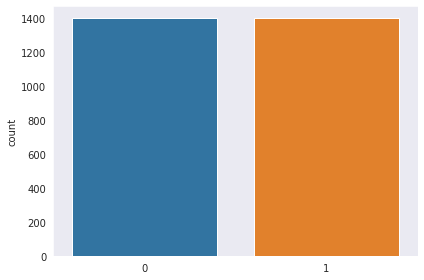

In [ ]:
# Checando o balanceamento das classes
print(pd.Series(y_train_rus_scaled).value_counts())

fig, ax = plt.subplots() 
sns.countplot(y_train_rus_scaled)

plt.tight_layout()

### Balanceamento com OverSampling SMOTE

Neste segundo balanceamento, SMOTE,são adicionadas entradas para a classe minoritária, com caracteristicas semelhantes as ja existentes.




1    3880
0    3880
dtype: int64


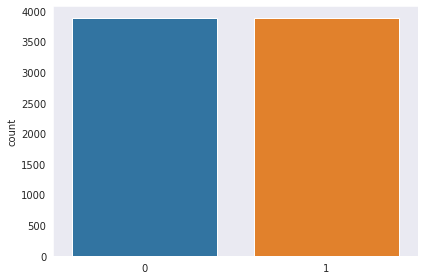

In [ ]:
# Checando o balanceamento das classes
print(pd.Series(y_train_smo_scaled).value_counts())

fig, ax = plt.subplots() 
sns.countplot(y_train_smo_scaled)

plt.tight_layout()

### Balanceamento com OverSampling ADASYN

O terceiro balanceamento, ADASYN, também adiciona entradas mas tenta fazer uma diferenciação das entradas ja existentes, levando em consideração a complexidade dos dados de cada entrada.

1    3892
0    3880
dtype: int64


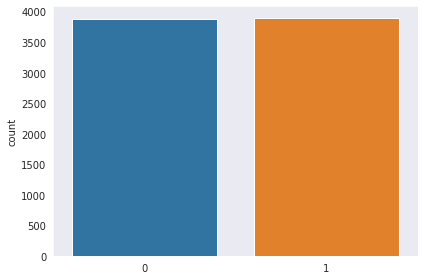

In [ ]:
print(pd.Series(y_train_ada_scaled).value_counts())

fig, ax = plt.subplots() 

sns.countplot(y_train_ada_scaled)


plt.tight_layout();

## Avaliandos Modelos com Cross-Validation (Dados Balanceados e Padronizados)

Como dito anteriormente, vou avaliar os modelos novamente, agora com os dados balanceados e padronizados, depois irei selecionar 3 modelos para cada tipo de balanceamento. Assim,posso usar o método ensemble para combinar os modelos e possivelmente obter um resultado mais constante e melhor.

In [ ]:
# Definindo funçao de validação com dados balanceados
def val_model_balanced(X, y,clf, quite=False):

  X = np.array(X)
  y = np.array(y)

  scores = cross_val_score(clf, X, y, scoring='recall')

  if quite == False:
    print('Recall: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))
  return scores.mean()

## Balanceamento RUS com StandardScaler (scaled)
As validações serão avaliadas pela métrica recall e serão dividas. Primeiramente, em balanceamentos e com subgrupos que depende do tipo de padronização utilizada.

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_rus_scaled, y_train_rus_scaled, sgd)

Cross-validation RF:
Recall: 0.7825 (+/- 0.0253)

Cross-validation LR:
Recall: 0.8160 (+/- 0.0268)

Cross-validation XGB:
Recall: 0.8267 (+/- 0.0387)

Cross-validation LDA:
Recall: 0.8088 (+/- 0.0342)

Cross-validation SVC:
Recall: 0.8003 (+/- 0.0249)

Cross-validation SGD:
Recall: 0.7489 (+/- 0.0739)


### Balanceamento RUS com RobustScaler (Rscaled)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, sgd)

Cross-validation RF:
Recall: 0.7689 (+/- 0.0464)

Cross-validation LR:
Recall: 0.7981 (+/- 0.0338)

Cross-validation XGB:
Recall: 0.8010 (+/- 0.0529)

Cross-validation LDA:
Recall: 0.7974 (+/- 0.0275)

Cross-validation SVC:
Recall: 0.7867 (+/- 0.0307)

Cross-validation SGD:
Recall: 0.7561 (+/- 0.1035)


### Balanceamento RUS com QuantileTransformer (QTR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_rus_qtr, y_train_rus_qtr, sgd)

Cross-validation RF:
Recall: 0.7746 (+/- 0.0412)

Cross-validation LR:
Recall: 0.7946 (+/- 0.0330)

Cross-validation XGB:
Recall: 0.8096 (+/- 0.0260)

Cross-validation LDA:
Recall: 0.8046 (+/- 0.0221)

Cross-validation SVC:
Recall: 0.8088 (+/- 0.0319)

Cross-validation SGD:
Recall: 0.8233 (+/- 0.3374)


### Balanceamento RUS com QuantileTransformer (uniform output)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, sgd)

Cross-validation RF:
Recall: 0.7667 (+/- 0.0340)

Cross-validation LR:
Recall: 0.8181 (+/- 0.0384)

Cross-validation XGB:
Recall: 0.8138 (+/- 0.0453)

Cross-validation LDA:
Recall: 0.8267 (+/- 0.0365)

Cross-validation SVC:
Recall: 0.8110 (+/- 0.0294)

Cross-validation SGD:
Recall: 0.6886 (+/- 0.4249)


### Balanceamento RUS com PowerTransformer (PWR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_rus_pwr, y_train_rus_pwr, sgd)

Cross-validation RF:
Recall: 0.7739 (+/- 0.0499)

Cross-validation LR:
Recall: 0.8038 (+/- 0.0325)

Cross-validation XGB:
Recall: 0.8352 (+/- 0.0444)

Cross-validation LDA:
Recall: 0.8096 (+/- 0.0280)

Cross-validation SVC:
Recall: 0.8067 (+/- 0.0364)

Cross-validation SGD:
Recall: 0.7676 (+/- 0.1522)


## Balanceamento SMOTE com StandardScaler (scaled)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_smo_scaled, y_train_smo_scaled, sgd)

Cross-validation RF:
Recall: 0.8719 (+/- 0.2336)

Cross-validation LR:
Recall: 0.8178 (+/- 0.0381)

Cross-validation XGB:
Recall: 0.8557 (+/- 0.2815)

Cross-validation LDA:
Recall: 0.8204 (+/- 0.0465)

Cross-validation SVC:
Recall: 0.8451 (+/- 0.1068)

Cross-validation SGD:
Recall: 0.8034 (+/- 0.1332)


#### Balanceamento SMOTE com RobustScaler (Rscaled)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, sgd)

Cross-validation RF:
Recall: 0.8768 (+/- 0.2312)

Cross-validation LR:
Recall: 0.8216 (+/- 0.0331)

Cross-validation XGB:
Recall: 0.8595 (+/- 0.2726)

Cross-validation LDA:
Recall: 0.8168 (+/- 0.0373)

Cross-validation SVC:
Recall: 0.8472 (+/- 0.1149)

Cross-validation SGD:
Recall: 0.8314 (+/- 0.0641)


#### Balanceamento SMOTE com QuantileTransformer (QTR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_smo_qtr, y_train_smo_qtr, sgd)

Cross-validation RF:
Recall: 0.8691 (+/- 0.2326)

Cross-validation LR:
Recall: 0.8090 (+/- 0.0461)

Cross-validation XGB:
Recall: 0.8631 (+/- 0.2649)

Cross-validation LDA:
Recall: 0.8139 (+/- 0.0408)

Cross-validation SVC:
Recall: 0.8631 (+/- 0.1367)

Cross-validation SGD:
Recall: 0.7711 (+/- 0.1670)


#### Balanceamento SMOTE com QuantileTransformer (uniform output)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, sgd)

Cross-validation RF:
Recall: 0.8753 (+/- 0.2161)

Cross-validation LR:
Recall: 0.8165 (+/- 0.0275)

Cross-validation XGB:
Recall: 0.8662 (+/- 0.2547)

Cross-validation LDA:
Recall: 0.8322 (+/- 0.0290)

Cross-validation SVC:
Recall: 0.8492 (+/- 0.1279)

Cross-validation SGD:
Recall: 0.7013 (+/- 0.2926)


#### Balanceamento SMOTE com PowerTransformer (PWR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_smo_pwr, y_train_smo_pwr, sgd)

Cross-validation RF:
Recall: 0.8719 (+/- 0.2344)

Cross-validation LR:
Recall: 0.8101 (+/- 0.0531)

Cross-validation XGB:
Recall: 0.8595 (+/- 0.2960)

Cross-validation LDA:
Recall: 0.8204 (+/- 0.0536)

Cross-validation SVC:
Recall: 0.8644 (+/- 0.1278)

Cross-validation SGD:
Recall: 0.7353 (+/- 0.1202)


## Balanceamento ADASYN com StandardScaler (scaled)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_ada_scaled, y_train_ada_scaled, sgd)


Cross-validation RF:
Recall: 0.8754 (+/- 0.1974)

Cross-validation LR:
Recall: 0.7970 (+/- 0.0914)

Cross-validation XGB:
Recall: 0.8536 (+/- 0.2742)

Cross-validation LDA:
Recall: 0.7849 (+/- 0.0986)

Cross-validation SVC:
Recall: 0.8703 (+/- 0.0440)

Cross-validation SGD:
Recall: 0.7898 (+/- 0.0628)


#### Balanceamento ADASYN com RobustScaler (Rscaled)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, sgd)

Cross-validation RF:
Recall: 0.8795 (+/- 0.1876)

Cross-validation LR:
Recall: 0.7912 (+/- 0.0895)

Cross-validation XGB:
Recall: 0.8531 (+/- 0.2658)

Cross-validation LDA:
Recall: 0.7837 (+/- 0.0987)

Cross-validation SVC:
Recall: 0.8699 (+/- 0.0457)

Cross-validation SGD:
Recall: 0.7665 (+/- 0.1661)


#### Balanceamento ADASYN com QuantileTransformer (QTR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_ada_qtr, y_train_ada_qtr, sgd)

Cross-validation RF:
Recall: 0.8839 (+/- 0.1847)

Cross-validation LR:
Recall: 0.7772 (+/- 0.0690)

Cross-validation XGB:
Recall: 0.8566 (+/- 0.2608)

Cross-validation LDA:
Recall: 0.7793 (+/- 0.0714)

Cross-validation SVC:
Recall: 0.8615 (+/- 0.0845)

Cross-validation SGD:
Recall: 0.7373 (+/- 0.2355)


#### Balanceamento ADASYN com QuantileTransformer (uniform output)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, sgd)

Cross-validation RF:
Recall: 0.8749 (+/- 0.2001)

Cross-validation LR:
Recall: 0.7929 (+/- 0.0707)

Cross-validation XGB:
Recall: 0.8580 (+/- 0.2667)

Cross-validation LDA:
Recall: 0.7962 (+/- 0.0756)

Cross-validation SVC:
Recall: 0.8695 (+/- 0.0978)

Cross-validation SGD:
Recall: 0.6560 (+/- 0.3559)


#### Balanceamento ADASYN com PowerTransformer (PWR)

In [ ]:
print('Cross-validation RF:')
score_teste1 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, rf)
print('\nCross-validation LR:')
score_teste2 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, lr)
print('\nCross-validation XGB:')
score_teste3 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, xgb)
print('\nCross-validation LDA:')
score_teste4 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, lda)
print('\nCross-validation SVC:')
score_teste5 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, svc)
print('\nCross-validation SGD:')
score_teste6 = val_model_balanced(X_ada_pwr, y_train_ada_pwr, sgd)

Cross-validation RF:
Recall: 0.8715 (+/- 0.2031)

Cross-validation LR:
Recall: 0.7685 (+/- 0.0933)

Cross-validation XGB:
Recall: 0.8536 (+/- 0.2899)

Cross-validation LDA:
Recall: 0.7729 (+/- 0.0931)

Cross-validation SVC:
Recall: 0.8735 (+/- 0.0399)

Cross-validation SGD:
Recall: 0.7690 (+/- 0.1376)


## Definindo Modelos para o Balanceamento RUS

Após realizar a validação de todos os modelos, com os 3 tipos de balanceamento e os 5 tipos de padronização, selecionei alguns modelos que obtiveram o melhor desempenho para o Balanceamento RUS. 

Serão usados os modelos:


* Linear Discriminant Analysis (LDA) - com padronização RobustScaler

* SVC - com padronização RobustScaler

* XGBoost (XBG) - com padronização RobustScaler   

Todos os três modelos passarão por um processo de otimização de seus respectivos hiperparâmetros, a fim de obtermos resultados ainda mais consistentes.





In [ ]:
model = []
recall= []

model.append('LinearDiscriminantAnalysis RusScaled')
recall.append(val_model_balanced(X_rus_scaled, y_train_rus_scaled, lda, quite=True))  
model.append('LinearDiscriminantAnalysis RusRscaled')
recall.append(val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, lda, quite=True))
model.append('LinearDiscriminantAnalysis RusQTR')
recall.append(val_model_balanced(X_rus_qtr, y_train_rus_qtr, lda, quite=True))
model.append('LinearDiscriminantAnalysis RusQTR-N')
recall.append(val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, lda, quite=True))
model.append('LinearDiscriminantAnalysis RusPWR')
recall.append(val_model_balanced(X_rus_pwr, y_train_rus_pwr, lda, quite=True))

model.append('SVC RusScaled')
recall.append(val_model_balanced(X_rus_scaled, y_train_rus_scaled, svc, quite=True))
model.append('SVC RusRscaled')
recall.append(val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, svc, quite=True))
model.append('SVC RusQTR')
recall.append(val_model_balanced(X_rus_qtr, y_train_rus_qtr, svc, quite=True))
model.append('SVC RusQTR-N')
recall.append(val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, svc, quite=True))
model.append('SVC RusPWR')
recall.append(val_model_balanced(X_rus_pwr, y_train_rus_pwr, svc, quite=True))

model.append('XGBoost RusScaled')
recall.append(val_model_balanced(X_rus_scaled, y_train_rus_scaled, xgb, quite=True))  
model.append('XGBoost RusRscaled')
recall.append(val_model_balanced(X_rus_Rscaled, y_train_rus_Rscaled, xgb, quite=True))
model.append('XGBoost RusQTR')
recall.append(val_model_balanced(X_rus_qtr, y_train_rus_qtr, xgb, quite=True))
model.append('XGBoost RusQTR-N')
recall.append(val_model_balanced(X_rus_qtr_n, y_train_rus_qtr_n, xgb, quite=True))
model.append('XGBoost RusPWR')
recall.append(val_model_balanced(X_rus_pwr, y_train_rus_pwr, xgb, quite=True))


pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
LinearDiscriminantAnalysis RusScaled,0.808846
LinearDiscriminantAnalysis RusRscaled,0.797433
LinearDiscriminantAnalysis RusQTR,0.804558
LinearDiscriminantAnalysis RusQTR-N,0.826680
LinearDiscriminantAnalysis RusPWR,0.809558
SVC RusScaled,0.800292
SVC RusRscaled,0.786734
SVC RusQTR,0.808849
SVC RusQTR-N,0.810991
SVC RusPWR,0.806711


### Otimizando Hiperparâmetros Linear Discriminant Analysis (LDA)

O modelo LDA possui poucos hiperparâmetros para serem otimizados, mas garanto que eles fazem diferença e nos darão um resultado bem interessante.

Pode-se notar que:

* O melhor desempenho do modelo foi com `Shrinkage: auto` e `solver: lsqr` 
* Com essas configurações obtemos um recall de 0.80

É normal que o recall seja alto na hora de realizar a otimização dos hiperparâmetros, portanto não estranhe caso o recall seja menor na avaliação de desempenho do modelo.

In [ ]:
# Modelo a ser otimizado
lda_rus_Rscaled = LinearDiscriminantAnalysis()

# Parâmetros a serem otimizados
param_grid = {
    'solver':('svd', 'lsqr', 'eigen'),
    'shrinkage':('auto', 'None')
}

# Identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lda_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

# Ver resultados
print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8052887537993921 para {'shrinkage': 'auto', 'solver': 'lsqr'}


#### Avaliando o Desempenho do Modelo LDA

Vamos realizar o treino do modelo, após isso será realizada a avaliação do desempenho final do modelo com os dados de teste, assim é possível ter uma noção de como esse modelo lida e irá lidar com dados novos.

              precision    recall  f1-score   support

           0     0.9036    0.7102    0.7953      1294
           1     0.4960    0.7901    0.6094       467

    accuracy                         0.7314      1761
   macro avg     0.6998    0.7502    0.7024      1761
weighted avg     0.7955    0.7314    0.7460      1761

AUC: 0.7502



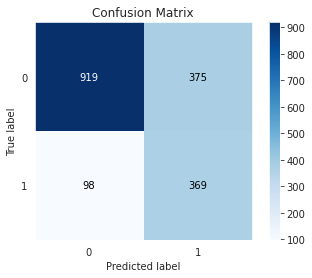

In [ ]:
# Modelo final
lda_rus_Rscaled = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# Treinar modelo
lda_rus_Rscaled.fit(X_rus_Rscaled, y_train_rus_Rscaled)

# Padronizar dados de Teste
X_test_Rscaled = Rob_scaler.fit_transform(X_test)

# Fazer previsões em cima dos dados de teste
y_pred_lda = lda_rus_Rscaled.predict(X_test_Rscaled)

# Plotar matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lda)

# Imprimir Relatório de Classificaçã
print(classification_report(y_test, y_pred_lda, digits=4))

# Imprimir área sob curva
print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_lda)))


### Otimizando Hiperparâmetros SVC

O modelo SVC possui diversos parâmetros, uma quantidade considerável a mais que o modelo LDA.

Devido a essa quantidade maior de parâmetros, podemos otimizar ainda mais o modelo e obter um resultado ainda melhor. Entretanto, esse modelo se sai melhor apenas na otimização.

Neste primeiro momento, vou buscar quais seriam os melhores valores para os parâmetros `C` e `kernel`.

* O parâmetro `Kernel` seleciona o tipo de hiperplano usado para separar os dados. O uso de 'linear' utilizará um hiperplano linear (uma linha no caso de dados 2D). O 'rbf' e o 'poly' usam um hiperplano não linear 

* `C` é o parâmetro de penalidade do termo de erro. Ele controla o trade off entre o limite de decisão suave e a classificação correta dos pontos de treinamento. 





In [ ]:
svc_rus_Rscaled = SVC()
param_grid = {
    'C':[0.01, 0.1, 1.0, 10],
    'kernel':('linear', 'poly', 'rbf', 'sigmoid')
      
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(svc_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9236372847011145 para {'C': 0.01, 'kernel': 'poly'}


Uma vez com os parâmetros `C` e `kernel` definidos e tendo um hiperplano não linear, podemos começar as buscas pelo melhor parâmetero `gamma` e aproveitar para buscar pelo parâmetro `degree`.

* `gamma` é um parâmetro para hiperplanos não lineares. Quanto mais alto o valor `gamma`, ele tenta se ajustar exatamente ao conjunto de dados de treinamento, isso pode gerar um problema quando os valores são muito altos, causando o overfitting.

* `degree` é um parâmetro usado quando o kernel é definido como 'poly'. É basicamente o grau do polinômio usado para encontrar o hiperplano para dividir os dados.

In [ ]:
svc_rus_Rscaled = SVC(C=0.01, kernel='poly')
param_grid = {
    'degree':[3, 5, 7],
    'gamma':[1, 1.5]
      
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(svc_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')


Melhor: 0.7859979736575481 para {'degree': 3, 'gamma': 1}


#### Avaliando o Desempenho do Modelo SVC

É possível notar que houve uma diminuição no desempenho, mesmo estando com os parâmetros otimizados, mas com isso podemos ter um resultado mais consistente do que se os parâmetros fossem mantidos em seus valores padrão.

Vamos treinar o modelo em cima do dataset de treino e testar seu desempenho com os dados de teste, vamos levar em consideração a métrica `recall`, assim pode-se saber se o modelo está se saindo bem em identificar o Churn.

              precision    recall  f1-score   support

           0     0.8929    0.6638    0.7615      1294
           1     0.4556    0.7794    0.5750       467

    accuracy                         0.6945      1761
   macro avg     0.6743    0.7216    0.6683      1761
weighted avg     0.7769    0.6945    0.7121      1761

AUC: 0.7216



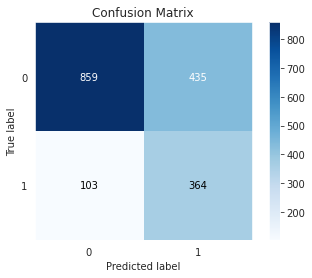

In [ ]:
svc_rus_Rscaled = SVC(C=0.01, kernel='poly', degree=3, gamma=1)

svc_rus_Rscaled.fit(X_rus_Rscaled, y_train_rus_Rscaled)

y_pred_SvcRus = svc_rus_Rscaled.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_SvcRus)

print(classification_report(y_test, y_pred_SvcRus, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_SvcRus)))


### Otimizando Hiperparâmetros XGBoost (XGB)

XGBoost possui diversos parâmetros, alguns que afetam ainda mais o desempenho do modelo e outros que nem tanto. O recomendado é começar definindo uma taxa de aprendizado e o número de estimadores, começar a procura por outros parâmetros e depois checar outras taxas de aprendizado.

Portanto, vamos começar a procura pelo `n_estimators` com o `learning_rate` instanciado em 0.01

In [ ]:
xgb_rus_Rscaled = XGBClassifier(learning_rate=0.01)
param_grid = {
    'n_estimators':[100, 200, 1000],
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8380851063829787 para {'n_estimators': 200}


Uma vez com o número de estimadores definido para 200, vou realizar a busca para os parâmetros `max_depth` e `min_child_weight.`

In [ ]:
xgb_rus_Rscaled = XGBClassifier(learning_rate=0.01, n_estimators=200)
param_grid = {
    'max_depth':[1, 3, 6],
    'min_child_weight':[1, 5, 10]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8573606889564337 para {'max_depth': 1, 'min_child_weitght': 1}


Após obter os valores `max_depth=1` e `min_child_weight=1`, é necessário começar a otimização do parâmetro `gamma`

In [ ]:
xgb_rus_Rscaled = XGBClassifier(learning_rate=0.01, n_estimators=200, max_depth=1, min_child_weight=1)
param_grid = {
    'gamma':[0, 1, 5]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8573353596757853 para {'gamma': 0}


Com `gamma=0`, chegou a hora de testar outros valores para `learning_rate`. Dessa forma, podemos otimizar ainda mais o modelo e saber qual valor nos entregará o melhor resultado.

In [ ]:
xgb_rus_Rscaled = XGBClassifier(n_estimators=200, max_depth=1, min_child_weight=1, gamma=0)
param_grid = {
    'learnig_rate':[0.01, 0.015, 0.1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_rus_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8095542046605877 para {'learnig_rate': 0.01}


#### Avaliando o Desempenho do Modelo XGB

De acordo com a cross-validation, definir um valor específico para a taxa de aprendizagem, fez com que o desempenho do modelo caísse, quando levamos em conta a métrica `recall` mas acredito que o cenário não será esse quando o modelo fizer as previsões.

Agora vou treinar o modelo em cima dos dados de treino, após o treino podemos verificar o desemepenho do modelo com base nas previsões feitas nos dados de teste, dados que o modelo não teve nenhum contato até agora.

              precision    recall  f1-score   support

           0     0.9105    0.6368    0.7494      1294
           1     0.4509    0.8266    0.5835       467

    accuracy                         0.6871      1761
   macro avg     0.6807    0.7317    0.6665      1761
weighted avg     0.7886    0.6871    0.7054      1761

AUC: 0.7317



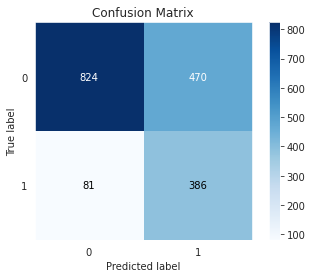

In [ ]:
xgb_rus_Rscaled = XGBClassifier(learning_rate=0.01 ,n_estimators=200, max_depth=1, min_child_weight=1, gamma=0)

xgb_rus_Rscaled.fit(X_rus_Rscaled, y_train_rus_Rscaled)

y_pred_XgbRus = xgb_rus_Rscaled.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_XgbRus)

print(classification_report(y_test, y_pred_XgbRus, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_XgbRus)))


## Método Ensemble para os Modelos do Balanceamento RUS

A fim de obter resultados mais consistentes e um desempenho ainda melhor, vou usar um método ensemble, que tem como objetivo combinar as previsões de diversos modelos. Para isso, vou usar os 3 modelos que foram trabalhados acima.

O método ensemble utilizados será o `VotingClassifier`, a previsão final que ele nos dá é a que ocorre com maior frequência.

Abaixo é possível ver que o `VotingClassifier` possui a maior pontuação de Recall dentre os 4 modelos, porém é apenas pouca coisa maior que a a pontuação do modelo `LDA`.

In [ ]:
xgb_ensemble_rus_Rscaled = XGBClassifier(learning_rate=0.01,n_estimators=200, max_depth=1, min_child_weight=1, gamma=0)
lda_ensemble_rus_Rscaled = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
svc_ensemble_rus_Rscaled = SVC(C=0.01, kernel='poly', degree=3, gamma=1, probability=True)
voting_clf_rus = VotingClassifier(estimators=[('XGB', xgb_ensemble_rus_Rscaled), ('LDA', lda_ensemble_rus_Rscaled), ('SVC', svc_ensemble_rus_Rscaled)])


for model in (xgb_ensemble_rus_Rscaled, lda_ensemble_rus_Rscaled, svc_ensemble_rus_Rscaled, voting_clf_rus):
  model.fit(X_rus_Rscaled, y_train_rus_Rscaled)

model = []
Recall = []

for clf in (xgb_ensemble_rus_Rscaled, lda_ensemble_rus_Rscaled, svc_ensemble_rus_Rscaled, voting_clf_rus):
  y_pred_ensemble = clf.predict(X_test_Rscaled)
  model.append(clf.__class__.__name__)
  Recall.append(recall_score(y_test, y_pred_ensemble))


pd.DataFrame(data=Recall, index=model, columns=["Recall"])


,Recall
XGBClassifier,0.826552
LinearDiscriminantAnalysis,0.766595
SVC,0.779443
VotingClassifier,0.785867


### Otimizando Hiperparâmetros Voting Classifier

O `VotingClassifier` possui uma quantidade pequena de parâmetros, sendo necessário especificar apenas o prâmetros `estimators`, onde serão passados os estimadores que serão utilizados. Porém, irei buscar a otimização de outros dois parâmetros, são eles:
* `Voting` - tendo como possibilidade os seguintes argumentos `hard` e `soft`
* `n_jobs` - esse é o número de trabaçhos realizados para o classificador se adequar.

In [ ]:
voting_clf_rus = VotingClassifier(estimators=[('XGB', xgb_ensemble_rus_Rscaled), ('LDA', lda_ensemble_rus_Rscaled), ('SVC', svc_ensemble_rus_Rscaled)])

param_grid = {
      'voting':('hard', 'soft')
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(voting_clf_rus, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8245288753799391 para {'voting': 'hard'}


Após a otimização do parâmetro `voting = hard` foi possível perceber uma melhora na métrica `recall` que subiu de 0.74 para 0.80. O próximo passo é  otimizar o parâmetro `n_jobs`, a fim de saber qual valor nos entregará o melhor desemepenho do classificador.

In [ ]:
voting_clf_rus = VotingClassifier(estimators=[('XGB', xgb_ensemble_rus_Rscaled), ('LDA', lda_ensemble_rus_Rscaled), ('SVC', svc_ensemble_rus_Rscaled)]
                              , voting='hard')
param_grid = {
        'n_jobs':range(-1, 3, 4)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(voting_clf_rus, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_Rscaled, y_train_rus_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')


Melhor: 0.8116919959473151 para {'n_jobs': -1}


#### Avaliando o Desempenho do Voting Classifier

Tendo otimizados os parâmetros do nosso `VotingClassifier`, vamos realizar sua avaliação de desempenho, agora entrando em contato com os dados de teste. 

É importante ficar de olho na coluna **recall**, referente ao **churn = 1**, ela nos mostra a quantidade de previsões certas quando o churn ocorre. 

Portanto, se fizermos uma comparação do desempenho individual de cada um dos modelos usados para compor o método ensemble, nota-se que o melhor desempenho foi o do **XGBoost** que obteve uma métrica do **recall = 0.6070** e preveu corretamente **349**, já o **VotingClassifier** obteve um valor um pouco melhor com o **recall = 0.611**4 e preveu corretamente, apenas um churn a mais, sendo **350**.

              precision    recall  f1-score   support

           0     0.8920    0.7465    0.8128      1294
           1     0.5162    0.7495    0.6114       467

    accuracy                         0.7473      1761
   macro avg     0.7041    0.7480    0.7121      1761
weighted avg     0.7923    0.7473    0.7594      1761

AUC: 0.7480



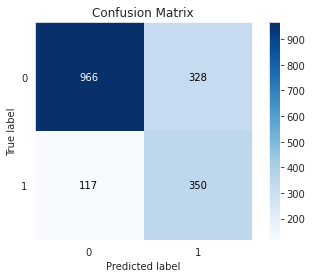

In [ ]:
voting_clf_rus = VotingClassifier(estimators=[('XGB', xgb_ensemble_rus_Rscaled), ('LDA', lda_ensemble_rus_Rscaled), ('SVC', svc_ensemble_rus_Rscaled)]
                              , voting='hard', n_jobs=-1)

voting_clf_rus.fit(X_rus_Rscaled, y_train_rus_Rscaled)

y_pred_voting_clf_rus = voting_clf_rus.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_voting_clf_rus)

print(classification_report(y_test, y_pred_voting_clf_rus, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_voting_clf_rus)))


## Definindo Modelos para o Balanceamento SMOTE

Após realizar todo o trabalho com os modelos que usaram o balanceamento RUS vou definir quais serão os 3 modelos usados para o balancemanto **SMOTE** 

Serão usados os modelos:

* **Random Forest (RF)** - com padronização RobustScaler

* **XGBoost (XBG)** - com padronização RobustScaler   

* **SGD** - com padronização RobustScaler

Todos os três modelos passarão por um processo de otimização de seus respectivos hiperparâmetros, a fim de obtermos resultados ainda mais consistentes.

In [ ]:
model = []
recall= []

model.append('Random Forest SmoScaled')
recall.append(val_model_balanced(X_smo_scaled, y_train_smo_scaled, rf, quite=True))  
model.append('Random Forest SmoRscaled')
recall.append(val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, rf, quite=True))
model.append('Random Forest SmoQTR')
recall.append(val_model_balanced(X_smo_qtr, y_train_smo_qtr, rf, quite=True))
model.append('Random Forest SmoQTR-N')
recall.append(val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, rf, quite=True))
model.append('Random Forest SmoPWR')
recall.append(val_model_balanced(X_smo_pwr, y_train_smo_pwr, rf, quite=True))

model.append('XGBoost smoScaled')
recall.append(val_model_balanced(X_smo_scaled, y_train_smo_scaled, xgb, quite=True))
model.append('XGBoost smoRscaled')
recall.append(val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, xgb, quite=True))
model.append('XGBoost smoQTR')
recall.append(val_model_balanced(X_smo_qtr, y_train_smo_qtr, xgb, quite=True))
model.append('XGBoost smoQTR-N')
recall.append(val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, xgb, quite=True))
model.append('XGBoost smoPWR')
recall.append(val_model_balanced(X_smo_pwr, y_train_smo_pwr, xgb, quite=True))

model.append('SGD smoScaled')
recall.append(val_model_balanced(X_smo_scaled, y_train_smo_scaled, sgd, quite=True))  
model.append('SGD smoRscaled')
recall.append(val_model_balanced(X_smo_Rscaled, y_train_smo_Rscaled, sgd, quite=True))
model.append('SGD smoQTR')
recall.append(val_model_balanced(X_smo_qtr, y_train_smo_qtr, sgd, quite=True))
model.append('SGD smoQTR-N')
recall.append(val_model_balanced(X_smo_qtr_n, y_train_smo_qtr_n, sgd, quite=True))
model.append('SGD smoPWR')
recall.append(val_model_balanced(X_smo_pwr, y_train_smo_pwr, sgd, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
Random Forest SmoScaled,0.861856
Random Forest SmoRscaled,0.867784
Random Forest SmoQTR,0.868557
Random Forest SmoQTR-N,0.865722
Random Forest SmoPWR,0.868041
XGBoost smoScaled,0.850515
XGBoost smoRscaled,0.853608
XGBoost smoQTR,0.856186
XGBoost smoQTR-N,0.854639
XGBoost smoPWR,0.847423


### Otimizando Hiperparâmetros do Modelo Random Forest (RF)

O algortimo de RandomForest é uma combinação de várias árvores de decisão que usa a média para melhorar a precisão de suas previsões.

Esse é um algoritmo que possui diversos parâmetros a serem otimizados, porém irei trabalhar apenas com os que me julgo capaz de otimizar e que aparentam ter mais impacto no desempenho do modelo.

Os primeiros parâmetros que irei otimizar, são os seguintes:
* `bootstrap` - caso seja falso, todo o conjunto de dados será usado na construção de cada árvore de decisão.

* `max_depth` - A profundidade máxima da árvore. Caso não seja especificado os nós são expandidos até que todas as folhas sejam puras ou até que as folhas possuam menos amostras que o `min_samples_split`

In [ ]:
rf_smo_Rscaled = RandomForestClassifier()
param_grid = {
  'bootstrap': [True, False],
  'max_depth': [5, 10, 20, 30, 40, 50, None],

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8984536082474225 para {'bootstrap': False, 'max_depth': 10}


Com o `bootstrap=False` e `max_depth=10`, irei realizar a busca pelos parâmetros `max_features` e `min_samples_leaf`.

* `max_features` - O número de características a considerar quando se procura a melhor divisão

* `min_samples_leaf` - número mínimo de amostras necessárias para estar em um nó de folha


In [ ]:
rf_smo_Rscaled = RandomForestClassifier(bootstrap=False, max_depth=10)
param_grid = {
    'max_features':[2, 3, 5],
    'min_samples_leaf':[3, 4, 5]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.88659793814433 para {'max_features': 3, 'min_samples_leaf': 3}


É possível notar que a o recall vem diminuindo desde a otimização dos primeiros parâmetros, mas por não ser uma diminuição gritante, decidi não considerar e continuar utilizando os valores decididos pelo `GridSearchCV` e `StratifiedKfold`.

Portanto, agora irei realizar a busca pelos seguintes parâmetros:

* `min_samples_split` - O número mínimo de amostras necessárias para dividir um nó interno

* `n_estimators` - O número de árvores na floresta

In [ ]:
rf_smo_Rscaled = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=3, min_samples_leaf=3)
param_grid = {
    'min_samples_split':[6, 8, 10, 12],
    'n_estimators':[100, 200, 300]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8855670103092784 para {'min_samples_split': 6, 'n_estimators': 300}


#### Avaliando o Desempenho do Modelo RF

Agora que todos os parâmetros foram otimizados, podemos realizar a avalição de desemepenho do modelo quando em contato com os dados de teste, estes que não entraram em contato com o modelo até o seguinte momento.

Como já foi dito anteriormente, a coluna **recall** é de extrema importância para sabermos se o modelo está obtendo um bom desempenho na previsão do churn.

Tendo em vista os modelos apresentados até aqui, o modelo de **Random Forest com balanceamento SMOTE** foi o que apresentou o melhor resultado na métrica **recall = 0.7302**, quando **churn = 1**.


              precision    recall  f1-score   support

           0     0.8888    0.7782    0.8298      1294
           1     0.5430    0.7302    0.6228       467

    accuracy                         0.7655      1761
   macro avg     0.7159    0.7542    0.7263      1761
weighted avg     0.7971    0.7655    0.7749      1761

AUC: 0.7542



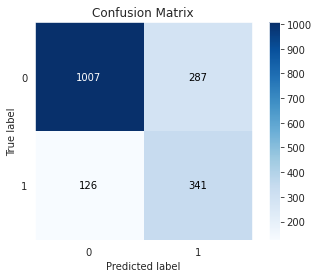

In [ ]:
rf_smo_Rscaled = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=3, min_samples_leaf=3, min_samples_split=6, n_estimators=300)

rf_smo_Rscaled.fit(X_smo_Rscaled, y_train_smo_Rscaled)

y_pred_rfSmo = rf_smo_Rscaled.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_rfSmo)

print(classification_report(y_test, y_pred_rfSmo, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_rfSmo)))



### Otimizando Hiperparâmetros Modelo XGBoost (XGB) 

O processo aqui é basicamente o mesmo que fiz anteriormente, a principal diferença serão os dados usados.

Portanto, mais uma vez irei começar a procura pelo `n_estimators` com o `learning_rate` instanciado em 0.01, também irei procurar pelo melhor valor para `max_depth`.

In [ ]:
xgb_smo_Rscaled = XGBClassifier(learning_rate=0.01)
param_grid = {
  'n_estimators':[100, 200, 300, 400],
  'max_depth':[1, 2, 3]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9028350515463917 para {'max_depth': 1, 'n_estimators': 100}


Se olharmos para a métrica, temos um valor impressionante de **0.9028**, porém é improvável que esse valor seja mantido quando o modelo for testado.

Com os valores para `max_depth` e `n_esimators` obtidos, vou realizar a busca pelos parâmetros `min_child_weight` e `gamma`. Após a busca, será realizada a verificação da melhor taxa de `learning_rate` para o modelo com os parâmetros otimizados.

In [ ]:
xgb_smo_Rscaled = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=1)
param_grid = {
  'min_child_weight':[1, 3, 5],
  'gamma':[0, 1, 5]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9077319587628866 para {'gamma': 0, 'min_child_weight': 1}


Com a otimização dos parâmetros, mais uma vez houve um aumento na métrica, nada muito relevante. Porém, é possível que com uma maior quantidade de dados para treinar o modelo poderia manter uma métrica próxima nos testes.

O próximo passo é realizar a busca da melhor taxa para `learning_rate`, uma vez que os parâmetros já foram otimizados.

In [ ]:
xgb_smo_Rscaled = XGBClassifier(n_estimators=100, max_depth=1, min_child_weight=1, gamma=0)
param_grid = {
  'learning_rate':[0.01, 0.02, 0.04, 0.1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9077319587628866 para {'learning_rate': 0.01}


#### Avaliando o Desempenho do Modelo XGB 

Diferente do primeiro modelo de XGBoost que usava os dados balanceados com RUS, esse não teve uma piora com a otimização de `learning_rate`, devido a isso, usarei o valor que foi dado.

Pode-se notar que esse modelo teve um desempenho bem inferior quando comparado seja ao modelo de Random Forest ou de XGBoost com dados RUS, tendo uma métrica **recall = 0.8672**, quando **churn = 1**. 

É notável que este modelo também possui uma grande quantidade de falsos positivos. Para não dizer que há apenas pontos negativos, podemos ressaltar a baixa quantidade de falsos negativos, mas é importante ressaltar que os falsos negativos podem ter se tornado dados falso positivo, dando origem a essa grande quantidade.

              precision    recall  f1-score   support

           0     0.9198    0.5495    0.6880      1294
           1     0.4099    0.8672    0.5567       467

    accuracy                         0.6337      1761
   macro avg     0.6649    0.7083    0.6223      1761
weighted avg     0.7846    0.6337    0.6531      1761

AUC: 0.7083



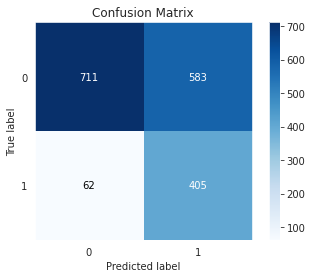

In [ ]:
xgb_smo_Rscaled = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=1, min_child_weight=1, gamma=0)

xgb_smo_Rscaled.fit(X_smo_Rscaled, y_train_smo_Rscaled)

y_pred_Xgbsmo = xgb_smo_Rscaled.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_Xgbsmo)

print(classification_report(y_test, y_pred_Xgbsmo, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_Xgbsmo)))


### Otimizando Hiperparâmetros do Modelo SGDClassifier (SGD)

Agora irei trabalhar com um modelo que obteve um ótimo desempenho a trabalhar com o balanceamento **SMOTE** e padronização **RobustScaler**.

Dessa vez, serão parâmetros novos com os quais ainda não trabalhei e por isso os resultados podem não ser os melhores, porém com uma boa otimização acredito que seja possível obter resultados relevantes.

Portanto, irei começar buscando os melhores valores para os parâmetros `loss` e `penalty`.

* `loss` - A função de perda a ser usada. O padrão é "hinge", o que dá uma SVM (Support Vector Machine) linear.

* `penalty` - A penalidade (também conhecida como termo de regularização) a ser usada. O padrão é o 'l2', que é o regularizador padrão para modelos lineares SVM.

In [ ]:
sgd_smo_Rscaled = SGDClassifier()
param_grid = {
    'loss':['hinge', 'log'],
    'penalty':['l2', 'l1'],

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(sgd_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8239690721649484 para {'loss': 'log', 'penalty': 'l2'}


Após obter os valores dos parâmetros que estava buscando, irei realizar a busca por outros 2 parâmetros bem importantes, porém irei definir `n_jobs=-1`.

Os parâmetros a serem otimizados, são:

* `alpha` - Constante que multiplica o termo de regularização. Quanto maior o valor, mais forte é a regularização.

* `max_iter` - O número máximo de passos sobre os dados de treinamento (também conhecidos como "**epochs**").

In [ ]:
sgd_smo_Rscaled = SGDClassifier(loss='log', penalty='l2')
param_grid = {
    'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'max_iter':[1000],
    'n_jobs':[-1]
  
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(sgd_smo_Rscaled, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8170103092783505 para {'alpha': 0.001, 'max_iter': 1000, 'n_jobs': -1}


#### Avaliando o Desempenho do Modelo SGD

Agora que os parâmetros foram otimizados, chegou a hora de avaliar o desempenho do Modelo e ver se ele obteve bons resultados. 

Dessa forma, sempre importante ficar de olho na coluna `recall` do relatório de classificação, também podemos ficar de olho na **AUC**, uma ótima métrica para mensurar o desempenho do Modelo.

Aqui é possível ver que o Modelo obteve excelentes resultados, porém outros modelos obtiveram resultados melhores na hora de prever o churn, mesmo que não tenham os valores mais atraentes nas métricas de avaliação.

              precision    recall  f1-score   support

           0     0.8937    0.7535    0.8176      1294
           1     0.5239    0.7516    0.6174       467

    accuracy                         0.7530      1761
   macro avg     0.7088    0.7525    0.7175      1761
weighted avg     0.7956    0.7530    0.7645      1761

AUC: 0.7525



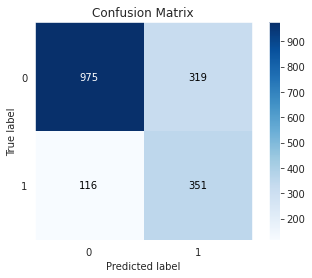

In [ ]:
sgd_smo_Rscaled = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=1000, n_jobs=-1)

sgd_smo_Rscaled.fit(X_smo_Rscaled, y_train_smo_Rscaled)

y_pred_sgdsmo = sgd_smo_Rscaled.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_sgdsmo)

print(classification_report(y_test, y_pred_sgdsmo, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_sgdsmo)))


## Método Ensemble para os Modelos do Balanceamento SMOTE

Vou usar o método ensemble `VotingClassifier` para combinar o resultado das previsões dos modelos acima. Dessa forma, podemos ter resultados ainda melhores ou mais consistentes.

Porém, o modelo com o melhor valor na métrica é o `XGBoost`, o que era de se esperar uma vez que foi o modelo que mais previu corretamente os churn.

In [ ]:
rf_ensemble_smo_Rscaled = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=100)
sgd_ensemble_smo_Rscaled = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=1000, n_jobs=-1) 
xgb_ensemble_smo_Rscaled = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=1, min_child_weight=1, gamma=0)
voting_clf_smo = VotingClassifier(estimators=[('RF', rf_ensemble_smo_Rscaled), ('SGD', sgd_ensemble_smo_Rscaled), ('XGB', xgb_ensemble_smo_Rscaled)])


for model in (rf_ensemble_smo_Rscaled, sgd_ensemble_smo_Rscaled, xgb_ensemble_smo_Rscaled, voting_clf_smo):
  model.fit(X_smo_Rscaled, y_train_smo_Rscaled)

model = []
Recall = []

for clf in (rf_ensemble_smo_Rscaled, sgd_ensemble_smo_Rscaled, xgb_ensemble_smo_Rscaled, voting_clf_smo):
  y_pred_ensemble = clf.predict(X_test_Rscaled)
  model.append(clf.__class__.__name__)
  Recall.append(recall_score(y_test, y_pred_ensemble))


pd.DataFrame(data=Recall, index=model, columns=["Recall"])

,Recall
RandomForestClassifier,0.706638
SGDClassifier,0.758030
XGBClassifier,0.869379
VotingClassifier,0.755889


### Otimizando Hiperparâmetros Voting Classifier

Mais uma vez, vou realizar a otimização dos parâmetros do `VotingClassifier`, buscando o parâmetro `voting`.

In [ ]:
voting_clf_smo = VotingClassifier(estimators=[('RF', rf_ensemble_smo_Rscaled), ('SGD', sgd_ensemble_smo_Rscaled), ('XGB', xgb_ensemble_smo_Rscaled)])
param_grid = {
      'voting':('hard', 'soft')
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(voting_clf_smo, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8667525773195877 para {'voting': 'hard'}


Após otimizar o parâmetro anterior, vou em busca do `n_jobs`.

In [ ]:
voting_clf_smo = VotingClassifier(estimators=[('RF', rf_ensemble_smo_Rscaled), ('SGD', sgd_ensemble_smo_Rscaled), ('XGB', xgb_ensemble_smo_Rscaled)]
                                  , voting='hard')
param_grid = {
      'n_jobs':[1, 3, -1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(voting_clf_smo, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_smo_Rscaled, y_train_smo_Rscaled)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8711340206185568 para {'n_jobs': -1}


#### Avaliando o Desempenho do Voting Classifier

Para avaliar o `VotingClassifier`, vamos utilizar como referência a coluna `recall` e a `confusion Matrix`. Dessa forma, podemos ter uma noção de quantos churns foram previsto corretamente.

              precision    recall  f1-score   support

           0     0.9001    0.7032    0.7896      1294
           1     0.4880    0.7837    0.6015       467

    accuracy                         0.7246      1761
   macro avg     0.6940    0.7435    0.6955      1761
weighted avg     0.7908    0.7246    0.7397      1761

AUC: 0.7435



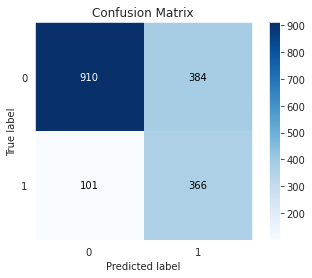

In [ ]:
voting_clf_smo = VotingClassifier(estimators=[('RF', rf_ensemble_smo_Rscaled), ('SGD', sgd_ensemble_smo_Rscaled), ('XGB', xgb_ensemble_smo_Rscaled)]
                                  , voting='hard', n_jobs=-1)

voting_clf_smo.fit(X_smo_Rscaled, y_train_smo_Rscaled)

y_pred_voting_clf_smo = voting_clf_smo.predict(X_test_Rscaled)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_voting_clf_smo)

print(classification_report(y_test, y_pred_voting_clf_smo, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_voting_clf_smo)))

## Definindo Modelos para o Balanceamento ADASYN

Após realizar todo o trabalho com os modelos que usaram o balanceamento SMOTE vou definir quais serão os 3 modelos usados para o balancemanto **ADASYN** 

Serão usados os modelos:

* **Random Forest (RF)** - com padronização RobustScaler

* **XGBoost (XBG)** - com padronização RobustScaler   

* **Linear Discriminant Analysis (LDA)** - com padronização RobustScaler

Todos os três modelos passarão por um processo de otimização de seus respectivos hiperparâmetros, a fim de obtermos resultados ainda mais consistentes.

In [ ]:
model = []
recall= []

model.append('Random Forest adaScaled')
recall.append(val_model_balanced(X_ada_scaled, y_train_ada_scaled, rf, quite=True))  
model.append('Random Forest adaRscaled')
recall.append(val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, rf, quite=True))
model.append('Random Forest adaQTR')
recall.append(val_model_balanced(X_ada_qtr, y_train_ada_qtr, rf, quite=True))
model.append('Random Forest adaQTR-N')
recall.append(val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, rf, quite=True))
model.append('Random Forest adaPWR')
recall.append(val_model_balanced(X_ada_pwr, y_train_ada_pwr, rf, quite=True))

model.append('XGBoost adaScaled')
recall.append(val_model_balanced(X_ada_scaled, y_train_ada_scaled, xgb, quite=True))
model.append('XGBoost adaRscaled')
recall.append(val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, xgb, quite=True))
model.append('XGBoost adaQTR')
recall.append(val_model_balanced(X_ada_qtr, y_train_ada_qtr, xgb, quite=True))
model.append('XGBoost adaQTR-N')
recall.append(val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, xgb, quite=True))
model.append('XGBoost adaPWR')
recall.append(val_model_balanced(X_ada_pwr, y_train_ada_pwr, xgb, quite=True))

model.append('Lda adaScaled')
recall.append(val_model_balanced(X_ada_scaled, y_train_ada_scaled, lda, quite=True))  
model.append('Lda adaRscaled')
recall.append(val_model_balanced(X_ada_Rscaled, y_train_ada_Rscaled, lda, quite=True))
model.append('Lda adaQTR')
recall.append(val_model_balanced(X_ada_qtr, y_train_ada_qtr, lda, quite=True))
model.append('Lda adaQTR-N')
recall.append(val_model_balanced(X_ada_qtr_n, y_train_ada_qtr_n, lda, quite=True))
model.append('Lda adaPWR')
recall.append(val_model_balanced(X_ada_pwr, y_train_ada_pwr, lda, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
Random Forest adaScaled,0.878273
Random Forest adaRscaled,0.876430
Random Forest adaQTR,0.880804
Random Forest adaQTR-N,0.878782
Random Forest adaPWR,0.872784
XGBoost adaScaled,0.853629
XGBoost adaRscaled,0.853075
XGBoost adaQTR,0.856611
XGBoost adaQTR-N,0.858036
XGBoost adaPWR,0.853566


### Otimizando Hiperparâmetros do Modelo Random Forest (RF)

Mais uma vez irei usar o Modelo Random Forest para fazer as previsões, sendo um dos modelos com o melhor desempenho.

Como ja foi feita uma vez a otimização dos parâmetros, irei apenas repetir esse processo, caso haja alguma diferença no resultado pela busca dos parâmetros.

In [ ]:
rf_ada_qtr = RandomForestClassifier()
param_grid = {
  'bootstrap': [True, False],
  'max_depth': [5, 10, 20, 30, 40, 50, None],

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9147675774520975 para {'bootstrap': False, 'max_depth': 10}


Uma vez definido os parâmetros `bootstrap` e `max_depth`, é necessário otimizar os parâmetros `max_features` e `min_samples_leaf.`

In [ ]:
rf_ada_qtr = RandomForestClassifier(bootstrap=False, max_depth=10)
param_grid = {
  'max_features': [3, 4, 5, 6],
  'min_samples_leaf': [2, 3, 4, 5, 6],

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9145052076431771 para {'max_features': 3, 'min_samples_leaf': 2}


Para podermos avaliar o desempenho do modelo, vamos otimzar os últimos parâmetros `min_samples_split` e `n_estimators`.

In [ ]:
rf_ada_qtr = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5, min_samples_leaf=2)
param_grid = {
    'min_samples_split':[8, 10, 12, 16],
    'n_estimators':[200, 300, 400],

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(rf_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.9142368748840537 para {'min_samples_split': 8, 'n_estimators': 200}


#### Avaliando o Desempenho do Modelo RF

Quando comparado ao Modelo que trabalhou com os **dados SMOTE** houve uma piora relativamente pequena, portanto o modelo RF anterior obteve resultados melhores do que esse.



              precision    recall  f1-score   support

           0     0.8836    0.7921    0.8354      1294
           1     0.5524    0.7109    0.6217       467

    accuracy                         0.7706      1761
   macro avg     0.7180    0.7515    0.7285      1761
weighted avg     0.7958    0.7706    0.7787      1761

AUC: 0.7515



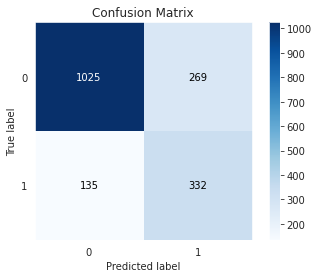

In [ ]:
rf_ada_qtr = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5, min_samples_leaf=2, n_estimators=300, min_samples_split=8)

rf_ada_qtr.fit(X_ada_qtr, y_train_ada_qtr)
X_test_qtr = qtr.fit_transform(X_test)

y_pred_rfAda = rf_ada_qtr.predict(X_test_qtr)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_rfAda)

print(classification_report(y_test, y_pred_rfAda, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_rfAda)))


### Otimizando Hiperparâmetros do Modelo XGBoost (XGB)

Esse modelo já teve duas otimizações e o processo é extremamente parecido. Portanto, não irei documentar todos os passos, apenas realizar a otimização para ver qual otimização será retornada para o Modelo.

In [ ]:
xgb_ada_qtr = XGBClassifier(learning_rate=0.01)
param_grid = {
    'n_estimators':[400, 500, 600],
    'max_depth':[3, 4, 5, 6]

}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8964792091802931 para {'max_depth': 3, 'n_estimators': 400}


In [ ]:
xgb_ada_qtr = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=400)
param_grid = {
  'gamma':[0, 1, 5],
  'min_child_weight':[1, 3, 5]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8918300956722233 para {'gamma': 5, 'min_child_weight': 5}


In [ ]:
xgb_ada_qtr = XGBClassifier(max_depth=5, n_estimators=400, gamma=1, min_child_weight=1)
param_grid = {
  'learning_rate':[0.01, 0.05, 0.1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.890544086078499 para {'learning_rate': 0.01}


#### Avaliando o Desempenho do Modelo XGB

Quando comparado aos outros dois modelos de XGB, esse obteve os melhores resultados na hora de realizar previsões de **verdadeiros negativos (churn = 0)**. Porém, foi o pior dos modelos na hora de realizar a previsão dos **verdadeiros positivos (churn = 1)**, foi o que menos preveu corretamente a ocorrência do churn, também houve um aumento considerável no número de falsos negativos, enquanto o modelo anterior teve **62 previsões de falsos negativos**, esse teve **mais que o dobro.**



              precision    recall  f1-score   support

           0     0.8734    0.7782    0.8230      1294
           1     0.5280    0.6874    0.5972       467

    accuracy                         0.7541      1761
   macro avg     0.7007    0.7328    0.7101      1761
weighted avg     0.7818    0.7541    0.7632      1761

AUC: 0.7328



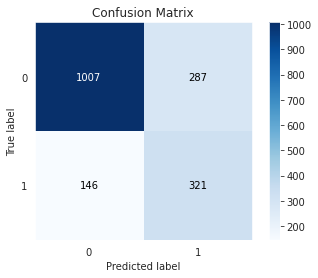

In [ ]:
xgb_ada_qtr = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=400, gamma=1, min_child_weight=1)
xgb_ada_qtr.fit(X_ada_qtr, y_train_ada_qtr)

y_pred_xgbAda = xgb_ada_qtr.predict(X_test_qtr)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgbAda)

print(classification_report(y_test, y_pred_xgbAda, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_xgbAda)))

### Otimizando Hiperparâmetros do Modelo Linear Discriminant Analysis (LDA)

Mais uma vez esse modelo aparecendo aqui, esse modelo obteve um **excelente desempenho** na hora de realizar as previsões, sempre tendo um ótimo número nas métricas de avaliação, como por exemplo, **o recall**.

Portanto, já foi um modelo que teve sua **otimização realizada 2x** e que possui poucos parâmetros a serem otimizados e por isso serei breve nesta etapa.

In [ ]:
lda_ada_qtr = LinearDiscriminantAnalysis()
param_grid = {
    'solver':['lsqr', 'svd', 'eigen'],
    'shrinkage':[0, 1, 0.01]
      
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lda_ada_qtr, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.7883152678027191 para {'shrinkage': 1, 'solver': 'lsqr'}


#### Avaliando o Desempenho do Modelo LDA

Apesar do excelente desempenho ao treinar com esses dados, pode-se notar que ele obteve resultados melhores quando treinou com dados RUS. 

Porém, é um **excelente modelo** e com um **desempenho acima da média** quando comparado com alguns outros modelos do projeto, mas ainda **está longe de ser o melhor modelo** e também não é o que eu recomendaria para ser implementado em uma empresa.

              precision    recall  f1-score   support

           0     0.8973    0.7025    0.7880      1294
           1     0.4853    0.7773    0.5975       467

    accuracy                         0.7223      1761
   macro avg     0.6913    0.7399    0.6928      1761
weighted avg     0.7881    0.7223    0.7375      1761

AUC: 0.7399



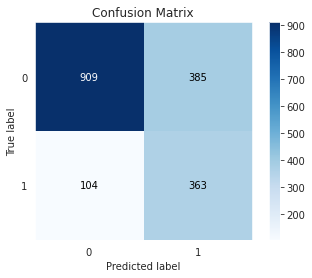

In [ ]:
lda_ada_qtr = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.01)

lda_ada_qtr.fit(X_ada_qtr, y_train_ada_qtr)

y_pred_ldaAda = lda_ada_qtr.predict(X_test_qtr)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_ldaAda)

print(classification_report(y_test, y_pred_ldaAda, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_ldaAda)))

## Método Ensemble para os Modelos do Balanceamento ADASYN

Mais uma vez vou combinar os 3 modelos que usaram os dados ADASYN para treinar, a fim de talvez obter um melhor resultado nas previsões e também resultados mais consistentes ao lidar com **dados novos**.

In [ ]:
rf_ensemble_ada_qtr = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5, min_samples_leaf=2, n_estimators=300, min_samples_split=8) 
xgb_ensemble_ada_qtr = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=400, gamma=1, min_child_weight=1) 
lda_ensemble_ada_qtr = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.01)
voting_clf_ada = VotingClassifier(estimators=[('RF', rf_ensemble_ada_qtr), ('XGB', xgb_ensemble_ada_qtr), ('LDA', lda_ensemble_ada_qtr)])


for model in (rf_ensemble_ada_qtr, xgb_ensemble_ada_qtr, lda_ensemble_ada_qtr, voting_clf_ada):
  model.fit(X_ada_qtr, y_train_ada_qtr)

model = []
Recall = []

for clf in (rf_ensemble_ada_qtr, xgb_ensemble_ada_qtr, lda_ensemble_ada_qtr, voting_clf_ada):
  y_pred_ensemble = clf.predict(X_test_qtr)
  model.append(clf.__class__.__name__)
  Recall.append(recall_score(y_test, y_pred_ensemble))


pd.DataFrame(data=Recall, index=model, columns=["Recall"])

,Recall
RandomForestClassifier,0.710921
XGBClassifier,0.704497
LinearDiscriminantAnalysis,0.811563
VotingClassifier,0.740899


### Otimizando Hiperparâmetros do Voting Classifier

Como das últimas vezes, os parâmetros otimizados são os mesmos. Dessa forma, a otimização é bem parecida com as anteriores.

In [ ]:
voting_clf_ada = VotingClassifier(estimators=[('RF', rf_ensemble_ada_qtr), ('XGB', xgb_ensemble_ada_qtr), ('LDA', lda_ensemble_ada_qtr)], voting='hard')
param_grid = {
      'voting':['soft', 'hard'],
      'n_jobs':[1, 2, -1]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(voting_clf_ada, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_ada_qtr, y_train_ada_qtr)

print(f'Melhor: {grid_result.best_score_} para {grid_result.best_params_}')

Melhor: 0.8857659856651052 para {'n_jobs': -1, 'voting': 'hard'}


#### Avaliando o Desempenho do Voting Classifier

Os modelos de Voting Classifier possuem resultados bem parecidos, até mesmo porque são constituídos quase que dos mesmos modelos, diferenciando apenas o segundo Voting Classifier que **não possui o modelo LDA** e sim o **SGD**, devido a isso, as previsões são parecidas e cometem os mesmo erros.

Porém, esse modelo foi o que menos fez previsões de **falsos negativos e de falsos positivos** também, isso pode ser benéfico para o consumidor que não sofrerá com as ligações indesejadas, mas provavelmente não é objetivo das empresas.

              precision    recall  f1-score   support

           0     0.8939    0.7813    0.8338      1294
           1     0.5508    0.7430    0.6326       467

    accuracy                         0.7712      1761
   macro avg     0.7223    0.7622    0.7332      1761
weighted avg     0.8029    0.7712    0.7805      1761

AUC: 0.7622



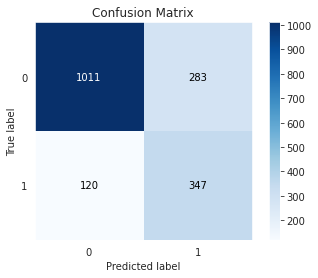

In [ ]:
voting_clf_ada = VotingClassifier(estimators=[('RF', rf_ensemble_ada_qtr), ('XGB', xgb_ensemble_ada_qtr), ('LDA', lda_ensemble_ada_qtr)], voting='hard', n_jobs=-1)

voting_clf_ada.fit(X_ada_qtr, y_train_ada_qtr)

y_pred_voting_clf_ada = voting_clf_ada.predict(X_test_qtr)

skplt.metrics.plot_confusion_matrix(y_test, y_pred_voting_clf_ada)

print(classification_report(y_test, y_pred_voting_clf_ada, digits=4))

print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred_voting_clf_ada)))

# Conclusão

O churn é algo que todas as empresas sofrem, até mesmo as grandes empresas. Porém, algo que pode ajudar a diminuir o churn e consequentemente alavancar o negócio é o churn prediction. 

Portanto, para lidar e amenizar o churn criei alguns modelos de Machine Learning a fim de prever o churn, de forma que a empresa possa contornar a situação e diminuir a sua taxa de clientes que param de usar o serviço.

O modelo que obteve os melhores resultados foi definitivamente o **modelo de árvore de decisão XGBoost** que foi treinado com os dados que foram **balanceados com o método SMOTE**. 

Esse modelo obteve:

* **405 previsões de churn** - o modelo que mais fez previsões corretas.

* **62 previsões de falsos negativos** - o modelo que menos deixou passar possíveis churns.

* **583 previsões de falsos positivos** -  foram feitas diversas previsões de falsos positivos. Porém, a empresa não teria problema em checar essas previsões, gerando aquelas ligações indesejadas que todos conhecemos.